# Benjamin Wilke
# NLP Final Exam

# Part 1.1

Given the GOP twitter dataset (a dataset of tweets from 2012 with 3 sentiments—see the attached file):

1. Build a model the predict the sentiment of the tweet based on a sequence of characters

2. Build a second model based on a sequence of bi-grams (2-letter sequences).

Please include ALL the code you used to develop this model.

In [1]:
import csv
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import numpy as np
import re

In [2]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:XLA_CPU:0', '/device:XLA_GPU:0', '/device:GPU:0']


## Prep Data for Character Sequence Model

In [3]:
rawTweets = list()    # initialize list of lists for each row in my file

with open('final.csv', newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        rawTweets.append(row)
        
rawTweets = rawTweets[1:]  # pop off the header row

In [4]:
# extract labels from each row
labels = [each[1] for each in rawTweets]
print("Length of labels is: {}".format(len(labels)))

Length of labels is: 13871


In [5]:
# extract Tweet from each row, removing pesky linebreaks and carriage returns
# let's also clean up some other stuff that is going to be REALLY noisy for this exercise

cleanText = list()

for each in rawTweets:
    tweet = each[2]
    tweet = tweet.replace("\n", "")  # remove linebreak
    tweet = tweet.replace("\r", "")  # remove carriage return
    if "RT @" in tweet:              # let's also remove RT + Twitter Usernames as these probably don't provide any predictive value
        idx = tweet.find(': ')
        tweet = tweet[idx + 2:]           # this only removes the first instance of a reTweet, and there can be more than one, but it's a start
    tweet = re.sub(r"http\S+", "", tweet) # remove URLs
    tweet = tweet.replace(" ", "")        # remove spaces. I was on the fence about this, but I think it's actually noisy
                                          # considering character and bigram sequences - especially how odd bigrams can be formed with space combinations
    tweet = tweet.replace("\"", "")       # strip quotes because they are also pretty random and noisy
    cleanText.append(tweet.strip())       # strip off trailing whitespace and add to our cleanText list

In [6]:
cleanText[703]

"IhatethephraseIjustcan'tbutI'mprettyclosetofeelingthatwayaboutthisGodquestion.#GOPDebate"

In [7]:
print("Length of raw text is: {}".format(len(cleanText)))

Length of raw text is: 13871


In [8]:
characterCounter = Counter()

In [9]:
# create count of each character in each Tweet across all Tweets
for tweet in cleanText:
    for char in tweet:
        characterCounter[char] += 1

In [10]:
characterCounter

Counter({'H': 2804,
         'o': 68747,
         'w': 16235,
         'd': 33605,
         'i': 60214,
         'e': 130519,
         'v': 7620,
         'r': 50823,
         'y': 17878,
         'n': 61512,
         'f': 13806,
         'l': 39007,
         'a': 86748,
         'b': 29378,
         'u': 28996,
         't': 91072,
         'h': 40222,
         'C': 5600,
         'm': 24535,
         'g': 19762,
         'q': 1040,
         's': 60340,
         '?': 2890,
         'E': 2406,
         'x': 3165,
         'c': 22468,
         '.': 13886,
         '#': 21643,
         'G': 17361,
         'O': 18215,
         'P': 17745,
         'D': 18119,
         "'": 5653,
         'S': 4293,
         '9': 194,
         '0': 1187,
         'W': 3731,
         'k': 10597,
         '1': 1405,
         '6': 709,
         'N': 3780,
         'T': 8864,
         'R': 3956,
         'F': 4125,
         '-': 1747,
         'j': 1542,
         'p': 19606,
         '…': 2307,
         '/': 

In [11]:
print("Total Characters is: {}".format(len(characterCounter)))

Total Characters is: 239


In [12]:
# create characterToIdx dict
characterToIdx = dict()

# add required entries for NLP tasks
characterToIdx['<<PAD>>'] = 0
characterToIdx['<<UNK>>'] = 1

currentIdx = 2
characterThreshold = 2

for char in characterCounter.keys():
    if characterCounter[char] > characterThreshold:    # only include characters that appear more than threshold times
        characterToIdx[char] = currentIdx              # set character index
        currentIdx += 1                                # increment index

In [13]:
characterToIdx

{'<<PAD>>': 0,
 '<<UNK>>': 1,
 'H': 2,
 'o': 3,
 'w': 4,
 'd': 5,
 'i': 6,
 'e': 7,
 'v': 8,
 'r': 9,
 'y': 10,
 'n': 11,
 'f': 12,
 'l': 13,
 'a': 14,
 'b': 15,
 'u': 16,
 't': 17,
 'h': 18,
 'C': 19,
 'm': 20,
 'g': 21,
 'q': 22,
 's': 23,
 '?': 24,
 'E': 25,
 'x': 26,
 'c': 27,
 '.': 28,
 '#': 29,
 'G': 30,
 'O': 31,
 'P': 32,
 'D': 33,
 "'": 34,
 'S': 35,
 '9': 36,
 '0': 37,
 'W': 38,
 'k': 39,
 '1': 40,
 '6': 41,
 'N': 42,
 'T': 43,
 'R': 44,
 'F': 45,
 '-': 46,
 'j': 47,
 'p': 48,
 '…': 49,
 '/': 50,
 '@': 51,
 '2': 52,
 'z': 53,
 ':': 54,
 'I': 55,
 'B': 56,
 'M': 57,
 'L': 58,
 'A': 59,
 ',': 60,
 '!': 61,
 'J': 62,
 'U': 63,
 '_': 64,
 '3': 65,
 '7': 66,
 '%': 67,
 '&': 68,
 ';': 69,
 '“': 70,
 '*': 71,
 '(': 72,
 'V': 73,
 '8': 74,
 ')': 75,
 'K': 76,
 '’': 77,
 '$': 78,
 'Y': 79,
 '5': 80,
 '\U000fe4e6': 81,
 '👉': 82,
 '4': 83,
 '”': 84,
 'X': 85,
 '=': 86,
 '😒': 87,
 '+': 88,
 '📢': 89,
 '➡': 90,
 '️': 91,
 '🇺': 92,
 '🇸': 93,
 '☑': 94,
 'Q': 95,
 'Z': 96,
 '🎀': 97,
 '–': 98,

In [14]:
# create reverse characterToIdx dict idxToCharacter (in case we need it later)
idxToCharacter = dict([(value, key) for (key, value) in characterToIdx.items()])

In [15]:
print("Total Characters after removing those that appear less than {0} times is: {1}".format(characterThreshold, len(characterToIdx.keys())))

Total Characters after removing those that appear less than 2 times is: 151


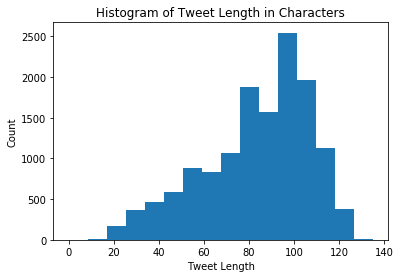

In [16]:
# let's find the distribution of sequence lengths to determine where we should set our max sequence
rawSeqLength = [len(tweet) for tweet in cleanText]
plt.hist(rawSeqLength, bins=16)
plt.xlabel("Tweet Length")
plt.ylabel("Count")
plt.title("Histogram of Tweet Length in Characters")
plt.show()

Interestingly - unlike most NLP projects where the max sequence length needs to be adjusted because of very long sequences in the training data - Twitter has a limit in length. This means we'll set our max sequence length to reflect the maximum Twitter length at the time of 140 characters (we will set to 120 since we removed spaces).

In [17]:
sequenceLength = 120
print("Our max sequence length for character model will be: {}".format(sequenceLength))

Our max sequence length for character model will be: 120


In [18]:
# let's also encode our labels, first verify possible values
print(list(set(labels)))
labelToIdx = {"Positive": 2, "Neutral": 1, "Negative": 0}
labelToIdx

['Positive', 'Neutral', 'Negative']


{'Positive': 2, 'Neutral': 1, 'Negative': 0}

In [19]:
# create one hot encoded labels (for model)
encodedLabels = np.array([labelToIdx[label] for label in labels])
oneHotEncodedLabels = to_categorical(encodedLabels)

In [20]:
# let's encode our sequences! 
encodedSequences = list()
for tweet in cleanText:
    encodedSequences.append([characterToIdx[char] if char in characterToIdx.keys() else 1 for char in tweet])

In [21]:
# now let's pad our sequences
encodedSequences = sequence.pad_sequences(encodedSequences, maxlen=sequenceLength)           

## Let's Create the Character Model

In [22]:
embedding_vector_length = 128

vocabulary_size = len(characterToIdx)
n_labels = len(labelToIdx)

model = Sequential()
model.add(Embedding(vocabulary_size, embedding_vector_length, input_length=sequenceLength, mask_zero=True))
model.add(LSTM(units=256, dropout=0.25))
model.add(Dense(n_labels, activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 128)          19328     
_________________________________________________________________
lstm (LSTM)                  (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 3)                 771       
Total params: 414,339
Trainable params: 414,339
Non-trainable params: 0
_________________________________________________________________


In [24]:
checkpoint = ModelCheckpoint('TweetSentiment_Model_Character.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

I originally ran this with validation_split, but then realized that it really doesn't matter for this task and probably want it to overfit the training data (to get the best representation of 😂 given the data vs. predicting unseen new data). I reran this with no validation_split and limited the epochs.

In [50]:
history = model.fit(encodedSequences, oneHotEncodedLabels, batch_size=8, epochs=10, shuffle=True, verbose=1)

Train on 13871 samples
Epoch 1/10
13871/13871 [==============================] - 237s 17ms/sample - loss: 0.3768 - accuracy: 0.8588
Epoch 2/10
13871/13871 [==============================] - 237s 17ms/sample - loss: 0.3393 - accuracy: 0.8721
Epoch 3/10
13871/13871 [==============================] - 237s 17ms/sample - loss: 0.3206 - accuracy: 0.8741
Epoch 4/10
13871/13871 [==============================] - 237s 17ms/sample - loss: 0.3136 - accuracy: 0.8802
Epoch 5/10
13871/13871 [==============================] - 237s 17ms/sample - loss: 0.3068 - accuracy: 0.8800
Epoch 6/10
13871/13871 [==============================] - 237s 17ms/sample - loss: 0.2990 - accuracy: 0.8832
Epoch 7/10
13871/13871 [==============================] - 237s 17ms/sample - loss: 0.2973 - accuracy: 0.8841
Epoch 8/10
13871/13871 [==============================] - 237s 17ms/sample - loss: 0.2904 - accuracy: 0.8878
Epoch 9/10
13871/13871 [==============================] - 237s 17ms/sample - loss: 0.2890 - accuracy: 0.8

In [51]:
model.save('TweetSentiment_Model_Character_NoVal.h5')

## Prep Data for BiGram Sequence Model

In [26]:
def extractBiGrams(tweet):
    biGramOutSeq = list()      # initialize our output list
    if len(tweet) % 2 != 0:    # length is odd
        tweet = tweet[:-1]     # chop last character off to make it even
    currentIdx = 0             # initialize current position
    for bigram in range(int(len(tweet) / 2)):                # for each bigram position (so half of total EVEN length)
        biGramOutSeq.append(tweet[currentIdx:currentIdx + 2])# get current bigram, add to biGramOutSeq
        currentIdx += 2                                      # increment to next biGram        
    return biGramOutSeq

In [27]:
# extract bigrams for each tweet sequence
biGramSequencesRaw = [extractBiGrams(tweet) for tweet in cleanText]

In [28]:
biGramSequencesRaw[234][:10]

['Ob', 'am', 'ab', 'et', 'te', 'rn', 'ot', 'le', 'av', 'eh']

In [29]:
print(''.join(biGramSequencesRaw[234]))

ObamabetternotleavehisprayerrugbehindintheOvalOfficewhenIgetelectedbecauseI'llthrowitout.#GOPDebat


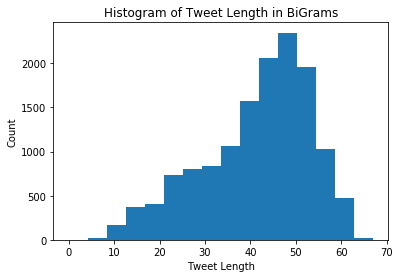

In [30]:
# let's find the distribution of sequence lengths in BIGRAMs to determine where we should set our max sequence
biGramLength = [len(tweet) for tweet in biGramSequencesRaw]
plt.hist(biGramLength, bins=16)
plt.xlabel("Tweet Length")
plt.ylabel("Count")
plt.title("Histogram of Tweet Length in BiGrams")
plt.show()

As we would expect it maxes out around half the length of total allowed Tweet size in characters (140), minus spaces, and divided by 2.

In [31]:
biGramSequenceLength = 60
print("Our max sequence length for bigram model will be: {}".format(biGramSequenceLength))

Our max sequence length for bigram model will be: 60


In [32]:
biGramCounter = Counter()        # init a counter for bigram counts
for tweet in biGramSequencesRaw:          # create count of each bigram in each Tweet across all Tweets
    for bigram in tweet:
        biGramCounter[bigram] += 1

In [33]:
biGramCounter

Counter({'Ho': 233,
         'wd': 53,
         'id': 1891,
         'ev': 794,
         'er': 5917,
         'yo': 1681,
         'ne': 2583,
         'fe': 462,
         'el': 2207,
         'ab': 1158,
         'ou': 3427,
         'tt': 1854,
         'he': 7701,
         'Cl': 241,
         'im': 1011,
         'at': 13290,
         'eC': 124,
         'ha': 3286,
         'ng': 4315,
         'eq': 205,
         'ue': 825,
         'st': 5338,
         'io': 2023,
         'nl': 305,
         'as': 2826,
         'tn': 586,
         'ig': 1650,
         'ht': 1468,
         '?E': 4,
         'xa': 37,
         'ct': 929,
         'ly': 1799,
         '.#': 1878,
         'GO': 7749,
         'PD': 6887,
         'eb': 9158,
         'Di': 167,
         'dn': 313,
         "'t": 1137,
         'ca': 2391,
         'tc': 870,
         'fu': 344,
         'll': 3471,
         '#G': 7416,
         'OP': 7455,
         'de': 3000,
         'ba': 8669,
         'te': 11466,
         'l

In [34]:
print("Length of all bigrams is: {}".format(len(biGramCounter)))

Length of all bigrams is: 4565


In [36]:
# create biGramToIdx dict
biGramToIdx = dict()

# add required entries for NLP tasks
biGramToIdx['<<PAD>>'] = 0
biGramToIdx['<<UNK>>'] = 1

currentIdx = 2
biGramThreshold = 2                              # drop bigrams occurring less than 2 times

for biGram in biGramCounter.keys():
    if biGramCounter[biGram] > biGramThreshold:  # only include characters that appear more than threshold times
        biGramToIdx[biGram] = currentIdx         # set character index
        currentIdx += 1                          # increment index

In [37]:
biGramToIdx

{'<<PAD>>': 0,
 '<<UNK>>': 1,
 'Ho': 2,
 'wd': 3,
 'id': 4,
 'ev': 5,
 'er': 6,
 'yo': 7,
 'ne': 8,
 'fe': 9,
 'el': 10,
 'ab': 11,
 'ou': 12,
 'tt': 13,
 'he': 14,
 'Cl': 15,
 'im': 16,
 'at': 17,
 'eC': 18,
 'ha': 19,
 'ng': 20,
 'eq': 21,
 'ue': 22,
 'st': 23,
 'io': 24,
 'nl': 25,
 'as': 26,
 'tn': 27,
 'ig': 28,
 'ht': 29,
 '?E': 30,
 'xa': 31,
 'ct': 32,
 'ly': 33,
 '.#': 34,
 'GO': 35,
 'PD': 36,
 'eb': 37,
 'Di': 38,
 'dn': 39,
 "'t": 40,
 'ca': 41,
 'tc': 42,
 'fu': 43,
 'll': 44,
 '#G': 45,
 'OP': 46,
 'de': 47,
 'ba': 48,
 'te': 49,
 'la': 50,
 'ni': 51,
 'gh': 52,
 't.': 53,
 'He': 54,
 're': 55,
 'ar': 56,
 'es': 57,
 'om': 58,
 'eo': 59,
 'fS': 60,
 'co': 61,
 "'s": 62,
 'be': 63,
 'li': 64,
 'si': 65,
 'n9': 66,
 '0s': 67,
 'ec': 68,
 'on': 69,
 'ds': 70,
 'Wa': 71,
 'lk': 72,
 '16': 73,
 'No': 74,
 'me': 75,
 'nt': 76,
 'no': 77,
 'fT': 78,
 'am': 79,
 'ir': 80,
 'Ri': 81,
 'ce': 82,
 'an': 83,
 'dt': 84,
 'De': 85,
 'wa': 86,
 'sh': 87,
 'di': 88,
 'nC': 89,
 'le': 90,

In [38]:
print("Length of all bigrams after dropping those that appear less than {0} times is: {1}".format(biGramThreshold, len(biGramToIdx)))

Length of all bigrams after dropping those that appear less than 2 times is: 2933


In [39]:
# let's encode our bigram sequences! 
encodedBiGramSequences = list()
for tweet in biGramSequencesRaw:
    encodedBiGramSequences.append([biGramToIdx[bigram] if bigram in biGramToIdx.keys() else 1 for bigram in tweet])

In [40]:
# create reverse characterToIdx dict idxToCharacter (in case we need it later)
idxToBigram = dict([(value, key) for (key, value) in biGramToIdx.items()])

In [41]:
encodedBiGramSequences[34][:10]

[260, 480, 8, 216, 120, 481, 482, 26, 483, 484]

In [42]:
''.join(biGramSequencesRaw[34])

'RTWinesdayPodcast:AnupdateonFoxNewstechfailuresforthe#GOPDebat'

In [43]:
# let's quick test the encoding worked by reversing... looks good. 
''.join([idxToBigram[idx] for idx in encodedBiGramSequences[34]])

'RTWinesdayPodcast:AnupdateonFoxNewstechfailuresforthe#GOPDebat'

In [44]:
# now let's pad our sequences
encodedBiGramSequences = sequence.pad_sequences(encodedBiGramSequences, maxlen=biGramSequenceLength)    

## Let's Create the BiGram Model

In [45]:
embedding_vector_length = 128

bigram_vocabulary_size = len(biGramToIdx)
n_labels = len(labelToIdx)

BGmodel = Sequential()
BGmodel.add(Embedding(bigram_vocabulary_size, embedding_vector_length, input_length=biGramSequenceLength, mask_zero=True))
BGmodel.add(LSTM(units=256, recurrent_dropout=0.25, dropout=0.25))  #<- also adding recurrent dropout to see if this can fit validation data better before overfitting
BGmodel.add(Dense(n_labels, activation="softmax"))

BGmodel.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [46]:
BGmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 128)           375424    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 770,435
Trainable params: 770,435
Non-trainable params: 0
_________________________________________________________________


In [47]:
BGcheckpoint = ModelCheckpoint('TweetSentiment_Model_BiGram.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

This one I kept the validation_split since there's no specific ask in the assignment on using the learned bi-gram embeddings (and I was curious on how accurate we could get without overfitting).

In [52]:
history = BGmodel.fit(encodedBiGramSequences, oneHotEncodedLabels, validation_split=0.2, callbacks=[BGcheckpoint], batch_size=8, epochs=15, shuffle=True, verbose=1)

Train on 11096 samples, validate on 2775 samples
Epoch 1/15
11088/11096 [============================>.] - ETA: 0s - loss: 0.2360 - accuracy: 0.9091
Epoch 00001: val_accuracy did not improve from 0.68360
11096/11096 [==============================] - 108s 10ms/sample - loss: 0.2360 - accuracy: 0.9091 - val_loss: 1.2540 - val_accuracy: 0.6695
Epoch 2/15
11088/11096 [============================>.] - ETA: 0s - loss: 0.2249 - accuracy: 0.9129
Epoch 00002: val_accuracy did not improve from 0.68360
11096/11096 [==============================] - 109s 10ms/sample - loss: 0.2248 - accuracy: 0.9129 - val_loss: 1.3445 - val_accuracy: 0.6580
Epoch 3/15
11088/11096 [============================>.] - ETA: 0s - loss: 0.2128 - accuracy: 0.9187
Epoch 00003: val_accuracy did not improve from 0.68360
11096/11096 [==============================] - 109s 10ms/sample - loss: 0.2127 - accuracy: 0.9188 - val_loss: 1.3280 - val_accuracy: 0.6584
Epoch 4/15
11088/11096 [============================>.] - ETA: 0s 

# Part 1.2

<b>2. What is the vector you learned for the following emoji:

😂

If you have trouble figuring out which face it is, the total count in the data set is 95
</b>

In [53]:
print("The Index of 😂 in my character tokenizer is: {}".format(characterToIdx['😂']))

The Index of 😂 in my character tokenizer is: 108


In [54]:
# extract word embeddings from character model
embeddings = model.layers[0].get_weights()[0]

In [57]:
# embeddings has a shape of (num_vocab, embedding_dim)
print('Shape of of extracted embeddings is: {}'.format(embeddings.shape))

Shape of of extracted embeddings is: (151, 128)


In [58]:
# create character to embedding dict 
character_embeddings = {w:embeddings[idx] for w, idx in characterToIdx.items()}

In [59]:
print(character_embeddings['😂']) 

[ 0.00342505  0.34389085 -0.17886627  0.03109402 -0.04163776 -0.15740158
  0.13264352 -0.02637714  0.02995085  0.1509479  -0.11548243  0.0764123
 -0.56685174  0.20987998  0.24796247  0.26823443 -0.08191358  0.23083575
  0.34119904  0.4208072  -0.02709019 -0.06146432  0.18034567 -0.18819043
 -0.05996726 -0.08917838  0.05226143 -0.33483243 -0.10959253  0.57164913
  0.2270133   0.09207559 -0.516086    0.03816625 -0.31253347 -0.18042538
  0.03320051 -0.01442632  0.28808674 -0.11822315  0.08565417 -0.43478063
  0.04839036 -0.365637   -0.01309108  0.27070397  0.09056404  0.25715342
  0.30630305 -0.21552975  0.07530943 -0.28317207 -0.297875    0.2521656
 -0.06132399  0.58525974  0.0430268  -0.3273234   0.20628606  0.257356
 -0.05906875 -0.2116436  -0.25825408  0.14029607 -0.3178163  -0.04451411
 -0.17170338 -0.32656643  0.2217629   0.41670424 -0.06081302  0.6893667
 -0.07123311 -0.0915882   0.30141804  0.08441024  0.01130753 -0.15520297
  0.23424183  0.05983843 -0.10953917  0.38635293  0.0039

# Part 1.3

<b>3. What is the most similar character for the above emoji 😂</b>

In [65]:
# The Cosine Similarity values for different documents, 1 (same direction), 0 (90 deg.), -1 (opposite directions).
# Cosine Distance, 1 - Cosine Similarity, then can take on values from 0 to 2 

from scipy.spatial import distance

In [71]:
# get distance of each character to 😂

characterDist = list()

for char, idx in characterToIdx.items():
    characterDist.append(scipy.spatial.distance.cosine(character_embeddings['😂'], character_embeddings[char]))

In [75]:
# zip distances against characters to create dict
characterDistDict = dict(zip(characterToIdx.keys(), characterDist))

In [76]:
characterDistDict

{'<<PAD>>': 1.0568311475217342,
 '<<UNK>>': 0.6103810966014862,
 'H': 1.0549499206244946,
 'o': 1.2729120254516602,
 'w': 0.9989539845846593,
 'd': 0.5237866342067719,
 'i': 1.1048607155680656,
 'e': 1.031117396429181,
 'v': 0.9010429754853249,
 'r': 1.075370080769062,
 'y': 1.0899633169174194,
 'n': 1.2093478292226791,
 'f': 0.8344277888536453,
 'l': 1.1925665438175201,
 'a': 0.867582768201828,
 'b': 1.2450850009918213,
 'u': 1.0471779629588127,
 't': 1.317717432975769,
 'h': 0.6298253834247589,
 'C': 0.9483337961137295,
 'm': 1.11024671792984,
 'g': 1.133236438035965,
 'q': 1.2357236444950104,
 's': 1.0211065150797367,
 '?': 0.9173202067613602,
 'E': 0.8503166884183884,
 'x': 1.2531802654266357,
 'c': 0.8520231395959854,
 '.': 1.2857770025730133,
 '#': 0.7485772967338562,
 'G': 1.0093223005533218,
 'O': 0.9964773345272988,
 'P': 0.620574563741684,
 'D': 1.1011904552578926,
 "'": 0.6439932584762573,
 'S': 0.8877584934234619,
 '9': 0.7332315742969513,
 '0': 0.7177881300449371,
 'W': 1.

In [77]:
# display dict sorted by value
{k: v for k, v in sorted(characterDistDict.items(), key=lambda item: item[1])}

{'😂': 0.0,
 '^': 0.5034654438495636,
 ',': 0.5074761807918549,
 '_': 0.5144933462142944,
 '’': 0.5154670178890228,
 'd': 0.5237866342067719,
 '4': 0.5292290151119232,
 '😏': 0.5502168834209442,
 '📢': 0.586395800113678,
 '<<UNK>>': 0.6103810966014862,
 'P': 0.620574563741684,
 'h': 0.6298253834247589,
 '2': 0.6330692172050476,
 'z': 0.6334448456764221,
 'V': 0.6382573544979095,
 "'": 0.6439932584762573,
 'I': 0.6458348631858826,
 '—': 0.6601552069187164,
 '@': 0.660656750202179,
 'R': 0.661930114030838,
 '|': 0.6777004301548004,
 '‘': 0.6800306737422943,
 '🙌': 0.6875149607658386,
 '[': 0.688608318567276,
 '-': 0.6957744359970093,
 '️': 0.6965802907943726,
 '8': 0.7052942514419556,
 '😶': 0.7078511416912079,
 'M': 0.7080160677433014,
 '6': 0.7154295444488525,
 '0': 0.7177881300449371,
 '🐘': 0.731357216835022,
 '9': 0.7332315742969513,
 '5': 0.741518646478653,
 '$': 0.7437134683132172,
 '#': 0.7485772967338562,
 '(': 0.7576823234558105,
 '=': 0.7620583027601242,
 '🎀': 0.772201731801033,
 '😭

Well...that's probably the most unsatisfying response I can think of!!!

Apparently the most similar character is '^'. 

I do like that it seems to be closest to 4 other special characters or punctuation, which makes sense intuitively versus characters or numbers. It's also close to 2 other emojis - interesting that the 'd' and the '4' are in there.

# Part 2.1

<b>Given the following paper: https://arxiv.org/pdf/1802.05365.pdf

Write an essay (min 500 words) Describing this model, how it is trained and on how this method captures each method described in the NLP pyramid.  Please cite specific passages where the paper mentions different levels.
</b>

ELMO word representations are computed using a two layer bidirectional language model (biLM) that utilizes character embeddings and convolutions. ELMO does not use word embeddings as inputs in the traditional sense, i.e. looking up a pretrained word embedding in a matrix of shape VOCAB x EMBEDDING LENGTH that is arbitrarily trained or pre-trained (as would be in the case of GloVe). It instead uses the actual characters in the word to retrieve character embeddings. As the character embeddings for a single word can become quite large (versus the size of simply a word embedding) a CNN layer is used to filter the information and pass to a max pooling layer. 

ELMo is pretrained on a large corpus, but then fine-tuned for both domain transfer and task. ELMo is integrated into NLP tasks by concatenating biLM learned representation with standard word embeddings. Once biLM representations are produced a linear combination of the internal layers is learned for the specific task. This is acheived by freezing the weights of trained language model, concatenating the ELMO representation, and then learning the weighting for the internal representation at each layer of the biLM and the word representation.


The authors do a great job of presenting how the various components of the biLM model contain different types of information and why including all the information together makes it so powerful. 

Lexical analysis is achieved in ELMO through the application character-based CNN representation and measured by the authors scores performing named entity recognition, "Following recent state-of-the-art systems, the baseline model uses pre-trained word embeddings, a character-based CNN representation, two biLSTM
layers and a conditional random field (CRF) loss...the key difference between our system and the previous state of the art is that we allowed the task model to learn a weighted average of all biLM layers". ELMo’s use of character embeddings allow it to pick up on morphological features at the word-level and can even form a basic representation of out-of-vocabulary words.

The authors measured the syntactic analysis capabilties of ELMo by measuring POS tagging, "To examine whether the biLM captures basic syntax, we used the context representations as input to a linear classifier that predicts POS tags with the Wall Street Journal portion
of the Penn Treebank (PTB)" 

Semantic analysis was measured through semantic role labeling (SRL), which models the structure of a sentence following: "who did what to whom". The paper states, "He et al. (2017) modeled SRL as a BIO tagging problem and used an 8-layer deep biLSTM with forward and backward directions interleaved. As shown in Table 1, when adding ELMo to a re-implementation of He et al. (2017) the single model test set F1 jumped 3.2% from 81.4% to 84.6%."

Discourse analysis is achieved through textual entailment, whether a hypothesis is true given a premise. The authors state that, "The Stanford Natural Language Inference (SNLI) corpus provides approximately 550K hypothesis/premise pairs...Overall, adding ELMo to the 
ESIM model improves accuracy by an average of 0.7% across five random seeds."